In [38]:
import os
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import pickle

FILE_NAME = "/opt/ml/input/data/origin_data.csv"
SAVE_DIR = "/opt/ml/input/meeting_data"

def stratified_choice_train_test_split(X, test_size=0.2, random_state=42):
  """ 라벨별로 일정 비율로 추출합니다 (ruw_label_to_num.pkl 경로 확인 필수)"""
  split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
  for train_idx, test_idx in split.split(X, X["category"]):
      X_train = X.iloc[train_idx]
      X_test = X.iloc[test_idx]
  return X_train, X_test

pd_dataset = pd.read_csv(FILE_NAME)
pd_train, pd_test = stratified_choice_train_test_split(pd_dataset, test_size=0.1, random_state=42)
pd_train, pd_validation = stratified_choice_train_test_split(pd_train, test_size=0.1, random_state=42)
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)
pd_train["id"] = list(range(len(pd_train)))
pd_validation["id"] = list(range(len(pd_train),len(pd_train)+len(pd_validation)))
pd_test["id"] = list(range(len(pd_train)+len(pd_validation),len(pd_train)+len(pd_validation)+len(pd_test)))
pd_train.to_csv(os.path.join(SAVE_DIR, "train.csv"), index=False)
pd_validation.to_csv(os.path.join(SAVE_DIR,"validation.csv"), index=False)
pd_test.to_csv(os.path.join(SAVE_DIR, "test.csv"), index=False)

print("========== train test split 완료 ==========")

========== train test split 완료 ==========


In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)

In [12]:
split.split(pd_dataset, pd_dataset["answers"])

<generator object BaseShuffleSplit.split at 0x7f214edc8270>

In [14]:
for train_idx, test_idx in split.split(pd_dataset, pd_dataset["category"]):
    X_train = pd_dataset.iloc[train_idx]
    X_test = pd_dataset.iloc[test_idx]

In [16]:
print(f"카테고리 수 : {X_train['category'].nunique()}")

카테고리 수 : 7


In [17]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 28.1 MB/s eta 0:00:00


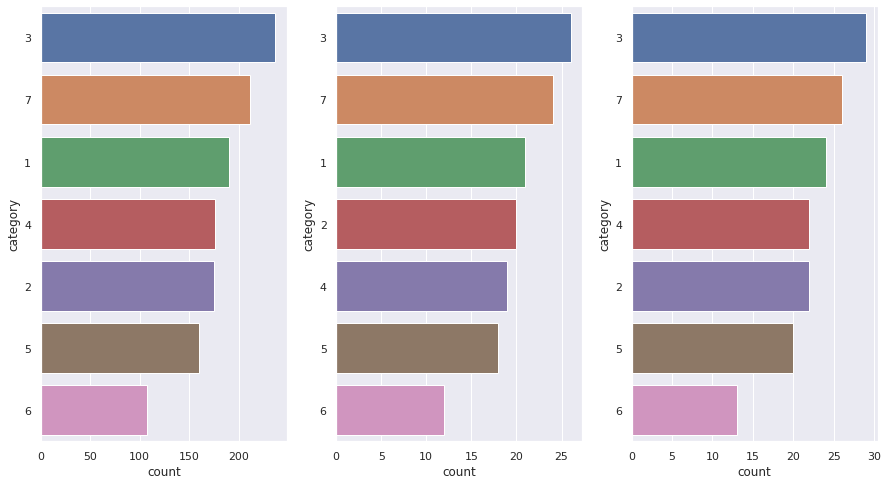

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(1, 4):
    axes = fig.add_subplot(1, 3, i)
    if i == 1:
        sns.countplot(y='category', data=pd_train, order=pd_train['category'].value_counts().index)
    elif i==2:
        sns.countplot(y='category', data=pd_validation, order=pd_validation['category'].value_counts().index)
    else:
        sns.countplot(y='category', data=pd_test, order=pd_test['category'].value_counts().index)


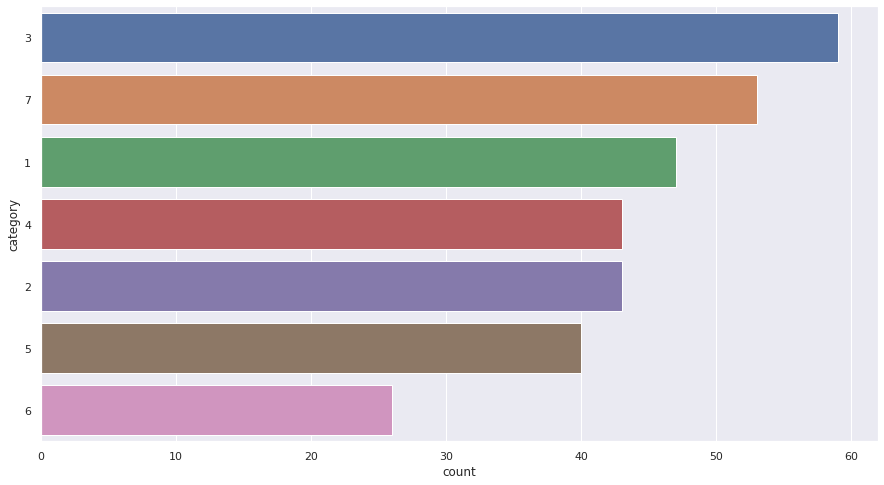

In [20]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(y='category', data=X_test, order=X_test['category'].value_counts().index)

In [35]:
import pyarrow.feather as feather
feather.write_feather(pd_train, '/opt/ml/input/meeting_data/train.arrow')
feather.write_feather(pd_validation, '/opt/ml/input/meeting_data/validation.arrow')
feather.write_feather(pd_test, '/opt/ml/input/meeting_data/test.arrow')

In [36]:
import pyarrow.dataset as ds
dataset = ds.dataset("/opt/ml/input/meeting_data/train.arrow", format="arrow")

In [37]:
ds.write_dataset(data=dataset, base_dir="/opt/ml/input/meeting_data/train_dataset/train", format="arrow")

In [40]:
from datasets import load_from_disk
datasets = load_from_disk("/opt/ml/input/data/train_dataset")
print(datasets["train"][0])

{'title': '미국 상원', 'context': '미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05', 'question': '대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?', 'id': 'mrc-1-000067', 'answers': {'answer_start': [2

In [41]:
pd_train

,category,document_id,question,answers,context
110,5,603772,제203회 완주군의회(임시회)를 휴회하는 이유는 뭘까?,"{'answer_start': 64, 'text': '상임위원회 의정활동을 위하여'}",@제203회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n다음은 의사일정 제5...
491,6,603566,제78회 회의에서 예산결산 특별위원회 위원으로 몇 명이 선임됐어?,"{'answer_start': 446, 'text': '열 두분'}",@제78회 전라북도 완주군의회 (제1차 정례회) 제1호 본 회 의 회 의 록@\n\...
314,4,604211,제129회 전라북도 완주군의회에서 운영위원회로 발탁된 사람이 누구더라?,"{'answer_start': 430, 'text': '송지용 의원, 임원규 의원,...",@제129회 전라북도 완주군의회(임시회) 제1호 본 회 의 회 의 록@\n\n좌석을...
634,3,603762,제123회 전라북도 완주군의회에서 제2회추가경정예산(안)에 대해 얘기하는 사람은 누구야?,"{'answer_start': 123, 'text': '기획감사실장 이방재'}",@제123회 전라북도 완주군의회(임시회) 제1호 본 회 의 회 의 록@\n\n다음은...
854,7,603921,"완주군자치법규입법예고에관한조례중개정조례안, 건국범국민추진위원회조례폐지조례안, 200...","{'answer_start': 1, 'text': '제105회 전라북도 완주군의회 ...",@제105회 전라북도 완주군의회 (임시회) 제2호 본 회 의 회 의 록@\n\n의사...
...,...,...,...,...,...
1049,1,604083,164회 의회에서 정한 휴회 기간을 언제부터 언제까지 가지려고 했었지?,"{'answer_start': 88, 'text': '9월 3일부터 9월 14일까지...",@제164회 전라북도 완주군의회(임시회) 제1호 본 회 의 회 의 록@\n\n다음은...
533,2,603654,제39회 전라북도 완주군의회 (임시회) 제1호 본회의의 다음 회의는 언제 진행해?,"{'answer_start': 322, 'text': '9월 18일 오전 10시'}",@제39회 전라북도 완주군의회 (임시회) 제1호 본회의회의록@\n\n다음은 지방자치...
164,6,604183,제231회 완주군의회 윤수봉 의원의 득표 수는 얼마야?,"{'answer_start': 0, 'text': '@'}",@제231회 완주군의회(임시회) 제1차 본 회 의 회 의 록@\n\n의사일정 제3항...
249,6,604080,8월 26일에 제안된 총 의안의 갯수는?,"{'answer_start': 646, 'text': '8건'}",@제164회 전라북도 완주군의회(임시회) 제1호 본 회 의 회 의 록@\n\n좌석을...
